# Blue Book for Bulldozers
## Data Wrangling

I have found, and am leveraging, detailed steps of the data wrangling process, as laid out in [this article](https://hevodata.com/learn/data-wrangling/):
- Step 1: Data Discovery
- Step 2: Data Structuring
- Step 3: Data Cleaning
- Step 4: Data Enriching
- Step 5: Data Validating
- Step 6: Data Publishing

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
df = pd.read_csv(
    '../data/raw/bluebook-for-bulldozers/TrainAndValid.csv',
    low_memory=False,
    parse_dates=['saledate'] # handle for time-series data 
)

### Data Discovery

In [3]:
df.shape

(412698, 53)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [5]:
df.shape

(412698, 53)

As the objctive of this project is price estimation, `SalePrice` is an obvious target variable. 

In [6]:
df.isna().sum().sort_values(ascending=False)

Engine_Horsepower           386715
Pushblock                   386715
Enclosure_Type              386715
Blade_Width                 386715
Blade_Extension             386715
Tip_Control                 386715
Scarifier                   386704
Grouser_Tracks              367823
Hydraulics_Flow             367823
Coupler_System              367724
fiModelSeries               354031
Steering_Controls           341176
Differential_Type           341134
UsageBand                   339028
fiModelDescriptor           337882
Backhoe_Mounting            331986
Stick                       331602
Turbocharged                331602
Pad_Type                    331602
Blade_Type                  330823
Travel_Controls             330821
Tire_Size                   315060
Track_Type                  310505
Grouser_Type                310505
Pattern_Changer             310437
Stick_Length                310437
Thumb                       310366
Undercarriage_Pad_Width     309782
Ripper              

We have a ton of NaN values that we'll have to manage.

In [7]:
df.head(1).T

,0
SalesID,1139246
SalePrice,66000.0
MachineID,999089
ModelID,3157
datasource,121
auctioneerID,3.0
YearMade,2004
MachineHoursCurrentMeter,68.0
UsageBand,Low
saledate,2006-11-16 00:00:00


In [8]:
len(df)

412698

This is a very large dataset, which, although it may take a long time to run our pre-processing steps, should yield great predictive power.

In [9]:
len(df.select_dtypes(include='object').columns) / len(df.columns)

0.8301886792452831

Over 80% of these columns are non-numerical, which means we'll have to convert them to categories, so they can be interpreted by a machine learning model.

<AxesSubplot:ylabel='Frequency'>

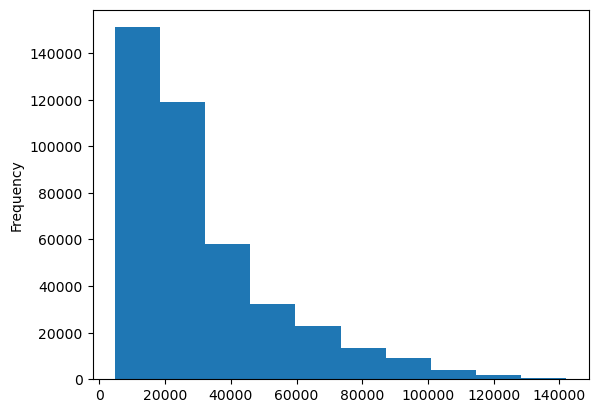

In [10]:
df.SalePrice.plot.hist()

This skew to the right is indicative of a lower limit -- in this case, a zero-dollar limit

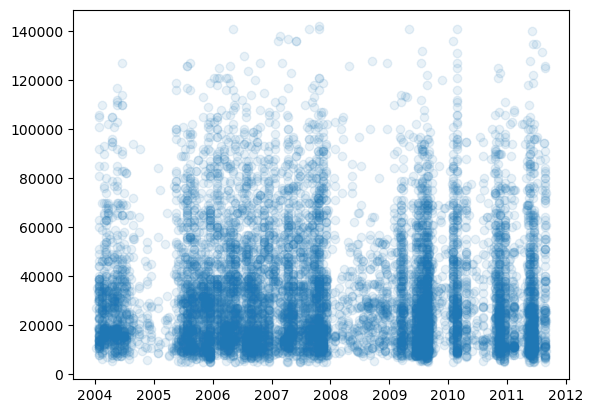

In [11]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:10000], df['SalePrice'][:10000], alpha=0.1)

Noticeing some seasonality, as points appear somewhat clustered in vertical lines.  Also, a bit of a deadzone after 2008, following the subprime mortgage crisis.

### Data Structuring

In [12]:
df.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Thankfully, this is a fairly clean dataset.  It's well-structured in that each row is an observation, while each column is a feature.  I don't think we need to do any structuring on this.

### Data Enriching

In [13]:
# sort by date
df.sort_values(by=['saledate'], ascending=True, inplace=True)

In [14]:
# expand on date-time features to expose patterns in seasonality
def enrich_date_features(df):
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDate'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    df = df.drop('saledate', axis=1)
    return df

In [15]:
df = enrich_date_features(df)

In [16]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleDate', 'saleDayOfWeek', 'saleDayOfYear'],
      dtyp

### Data Validating

In [17]:
df.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDate,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31


<AxesSubplot:>

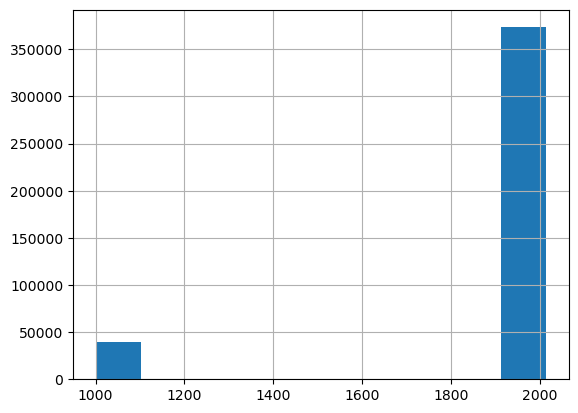

In [18]:
df.YearMade.hist()

Looks like we have nearly 50k rows with a `YearMade` value around 1000.  Acording to [this webpage](https://en.wikipedia.org/wiki/Bulldozer), the first bulldozer was made in 1923.

Let's take a closer look

In [19]:
year_made_outliers = df[df['YearMade'] < 1923]
len(year_made_outliers) / len(df)

0.09579644195028811

At nearly 10%, this is not insignificant.  We should decide whether to drop these rows, or impute them with a summary statistic.

In [20]:
# let's see what our histogram will look like if we impute the median
threshold = 1923
median = df[df['YearMade'] > threshold].YearMade.median()
df_copy = df.copy()
df_copy.loc[df_copy['YearMade'] < threshold, "YearMade"] = median
median

1996.0

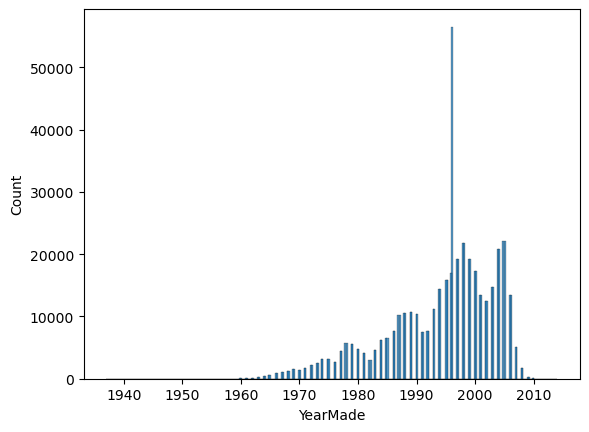

In [21]:
fig, ax = plt.subplots()
sns.histplot(df_copy.YearMade, ax=ax, kde=False)
sns.histplot(df[df['YearMade'] > threshold].YearMade, ax=ax, kde=False)
plt.show()

It appears we are getting a spike in the imputed median bucket, which, in this case, is 1996.  Given the magnitude of this spike, I think we should just drop the offending rows.

In [22]:
df = df[df['YearMade'] > threshold]

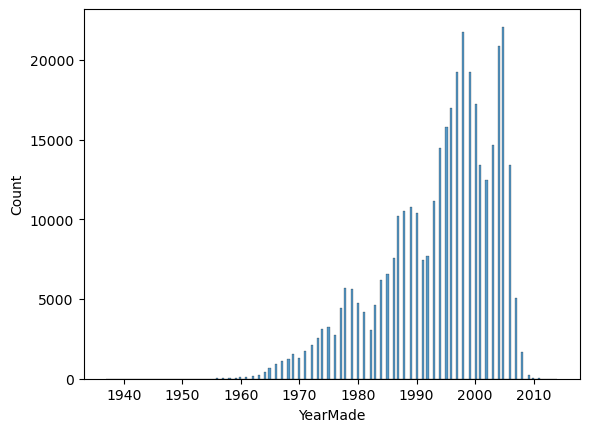

In [23]:
fig, ax = plt.subplots()
sns.histplot(df.YearMade, ax=ax, kde=False)
plt.show()

This looks like a more natural shape than the imputed one

Let's validate the state column:

In [24]:
len(df.state.unique())

53

In [25]:
df.state.isna().sum()

0

It seems we have an extra state

In [26]:
print(df.state.unique())

['Texas' 'Florida' 'Georgia' 'South Carolina' 'Oklahoma' 'Pennsylvania'
 'Arizona' 'Washington' 'Nevada' 'New Jersey' 'Colorado' 'California'
 'Indiana' 'Maryland' 'Utah' 'New Mexico' 'Wyoming' 'New York' 'Illinois'
 'Missouri' 'Connecticut' 'Kentucky' 'Louisiana' 'Tennessee' 'Minnesota'
 'Montana' 'North Dakota' 'Oregon' 'Kansas' 'Alabama' 'Maine' 'Ohio'
 'Virginia' 'Delaware' 'New Hampshire' 'Mississippi' 'Iowa' 'Wisconsin'
 'North Carolina' 'Vermont' 'Alaska' 'Idaho' 'Nebraska' 'Arkansas'
 'Rhode Island' 'South Dakota' 'Unspecified' 'Puerto Rico' 'West Virginia'
 'Massachusetts' 'Michigan' 'Hawaii' 'Washington DC']


Instead of `NaN`, we have the value `Unspecified`, which should be fine.

<AxesSubplot:>

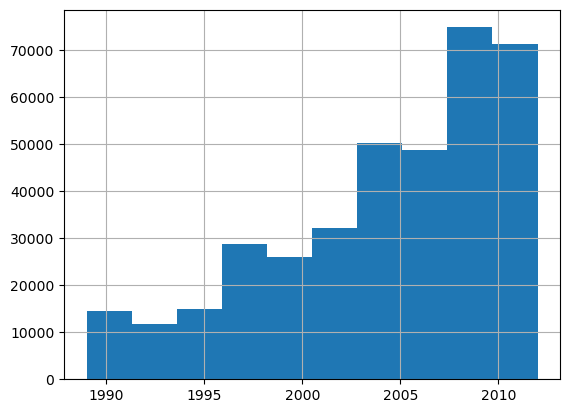

In [27]:
df.saleYear.hist()

In [28]:
df.MachineHoursCurrentMeter.max()

2483300.0

This value seems a little high.

In [29]:
df.MachineHoursCurrentMeter.max() / 24 / 365

283.48173515981733

283 years is far too many.  We need to trim that down by the maximum amount of possible years.  We can tighten this value by taking the maximum sale year, subtracting it by the year the first bulldozder appeared on the market, 1923, and trim any entries that exceed that value.

We're going to assume that a bulldozer will run, on average, 8 hours per day, five days a week.

In [30]:
hours_per_day = 8
days_per_year = 5 * 52
max_hours = (df.saleYear.max() - threshold) * days_per_year * hours_per_day

In [31]:
df[df['MachineHoursCurrentMeter'] > max_hours].shape[0]

248

Thirty-four is minimal.  I think we can just drop these, as the impact will be minimal since we have roughly 400K entries.

In [32]:
df.shape

(373163, 57)

In [33]:
df = df.drop(df[df['MachineHoursCurrentMeter'] > max_hours].index)

In [34]:
df.shape

(372915, 57)

In [35]:
df[df['MachineHoursCurrentMeter'] > max_hours].shape[0]

0

Offending entries have been successfully dropped

<AxesSubplot:>

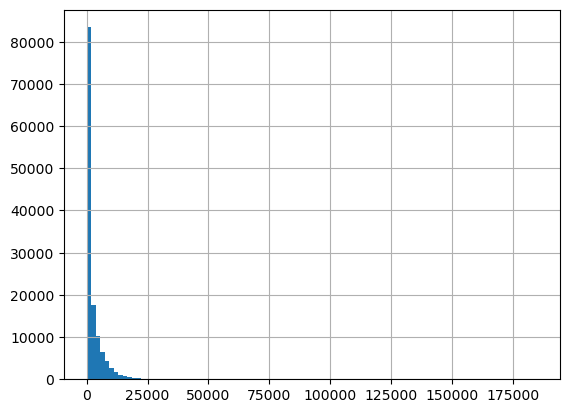

In [36]:
df.MachineHoursCurrentMeter.hist(bins=100)

### Data Publishing

In [37]:
df.to_csv('../data/processed/data-wrangling.csv', index=False)